In [1]:
# importing libraries
library(ggplot2)
library(reshape2)

Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'reshape2' was built under R version 3.6.3"

In [2]:
# reading the data
train.data = read.csv("Task2B_train.csv")
test.data = read.csv("Task2B_test.csv")

Warning message:
"Removed 2500 rows containing missing values (geom_text)."

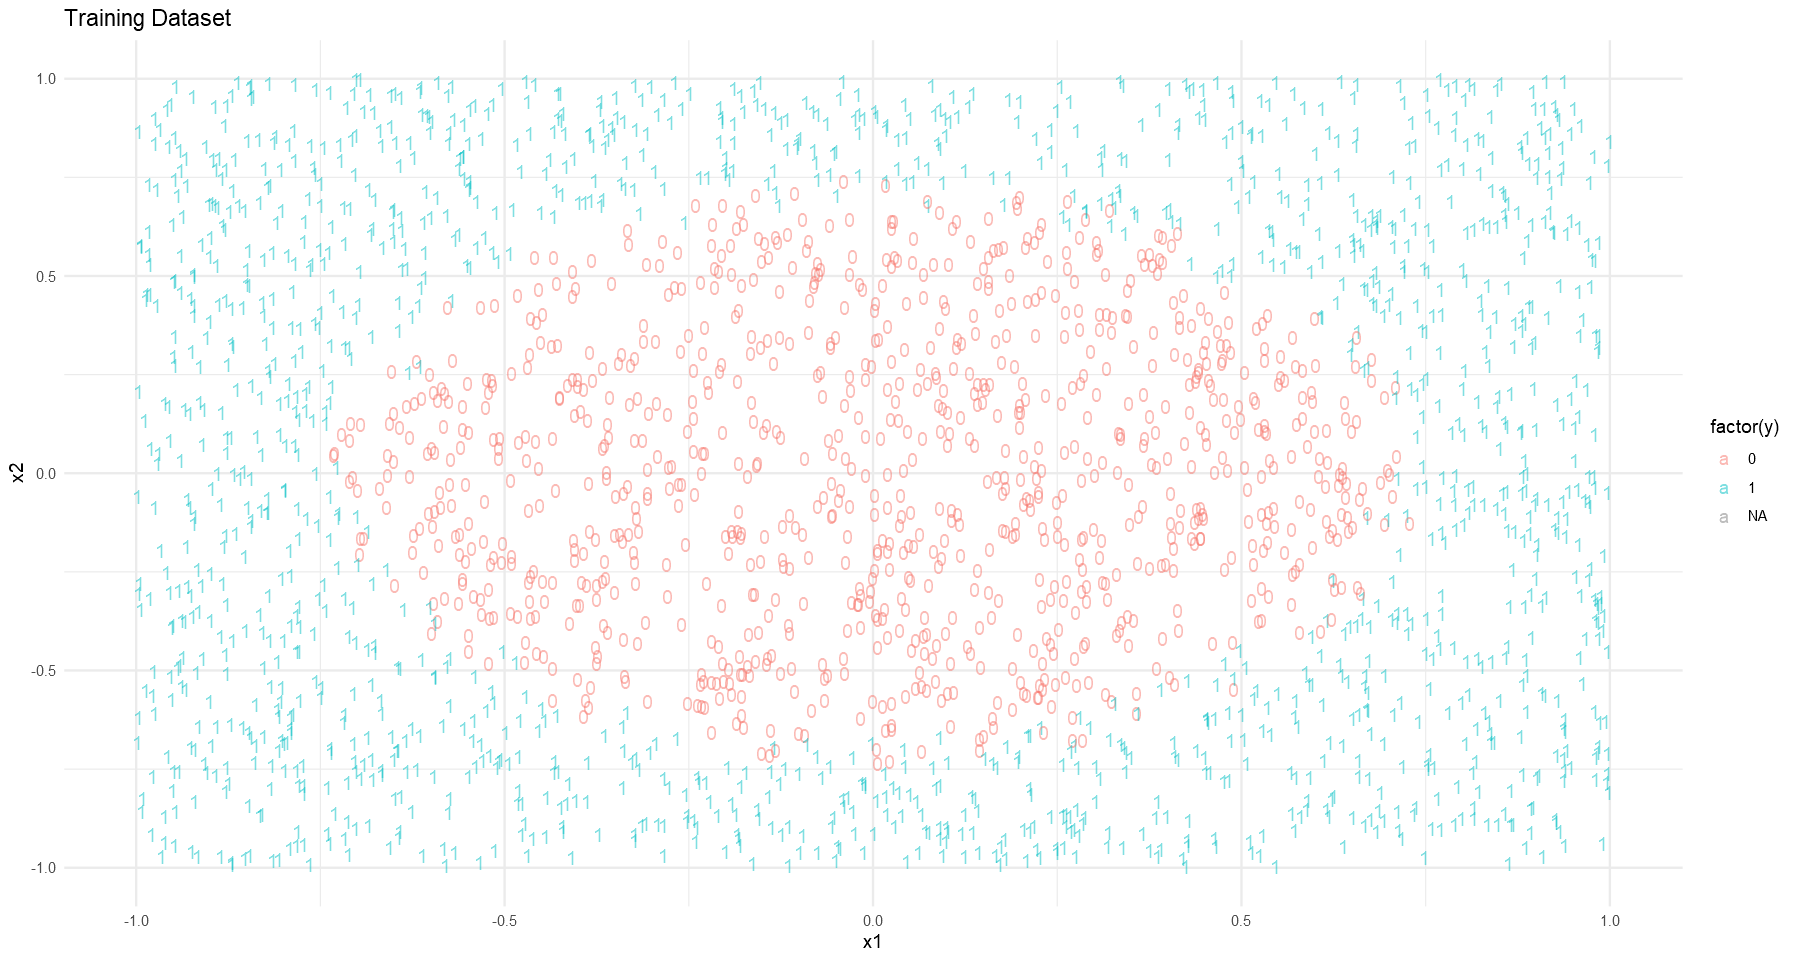

In [5]:
# Plotting the training data
options(repr.plot.width=15, repr.plot.height=8)
ggplot(data = train.data, aes(x = x1, y = x2, color = factor(y), label = ifelse(y == 0, '0', '1'))) +
    geom_text(size = 4, alpha = 0.5) + ggtitle ('Training Dataset') + theme_minimal()

In [6]:
####################### GENERAL AUXILIARY FUNCTIONS #######################
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

# reading the data
read.data <- function(file.name, scaling=FALSE) {
  data <- read.csv(file=file.name,head=TRUE,sep=",")
  data <- data[complete.cases(data),] # removes rows with NA values
  D <- ncol(data)
  x = data[,-D]
  y = data[,D]
  if (isTRUE(scaling)) {
    x = scale(x)
    y = scale(y)
  }
  return (list('x' = x, 'y' = y))
}

error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

In [7]:
####################### PERCEPTRON #######################
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

In [8]:
# cleaning the data and reformatting it
train.data = read.data("Task2B_train.csv")
train.x = train.data$x
train.y = train.data$y
train.y[train.y == 0] = -1
test.data = read.data("Task2B_test.csv")
test.x = train.data$x
test.y = train.data$y
test.y[test.y == 0] = -1
test.phi = as.matrix(cbind(1, test.x))

In [23]:
# building the perceptron with eta = 0.01
perceptron.01 = perceptron.build(train.x, train.y, eta = 0.01, epsilon = 0.001, tau.max = 1000, plotting = FALSE)
# predicting the labels
test.fit.01 <- perceptron.predict(test.phi, perceptron.01)
# error rate
test.error.01 <- error.rate(test.fit.01, test.y)
cat("Test Error Rate(%) when eta = 0.01 is", test.error.01 * 100)

Test Error Rate(%) when eta = 0.01 is 53.88

In [24]:
# building the perceptron with eta = 0.09
perceptron.09 = perceptron.build(train.x, train.y, eta = 0.09, epsilon = 0.001, tau.max = 1000, plotting = FALSE)
# predicting the labels
test.fit.09 <- perceptron.predict(test.phi, perceptron.09)
# error rate
test.error.09 <- error.rate(test.fit.09, test.y)
cat("Test Error Rate(%) when eta = 0.09 is", test.error.09 * 100)

Test Error Rate(%) when eta = 0.09 is 41.52

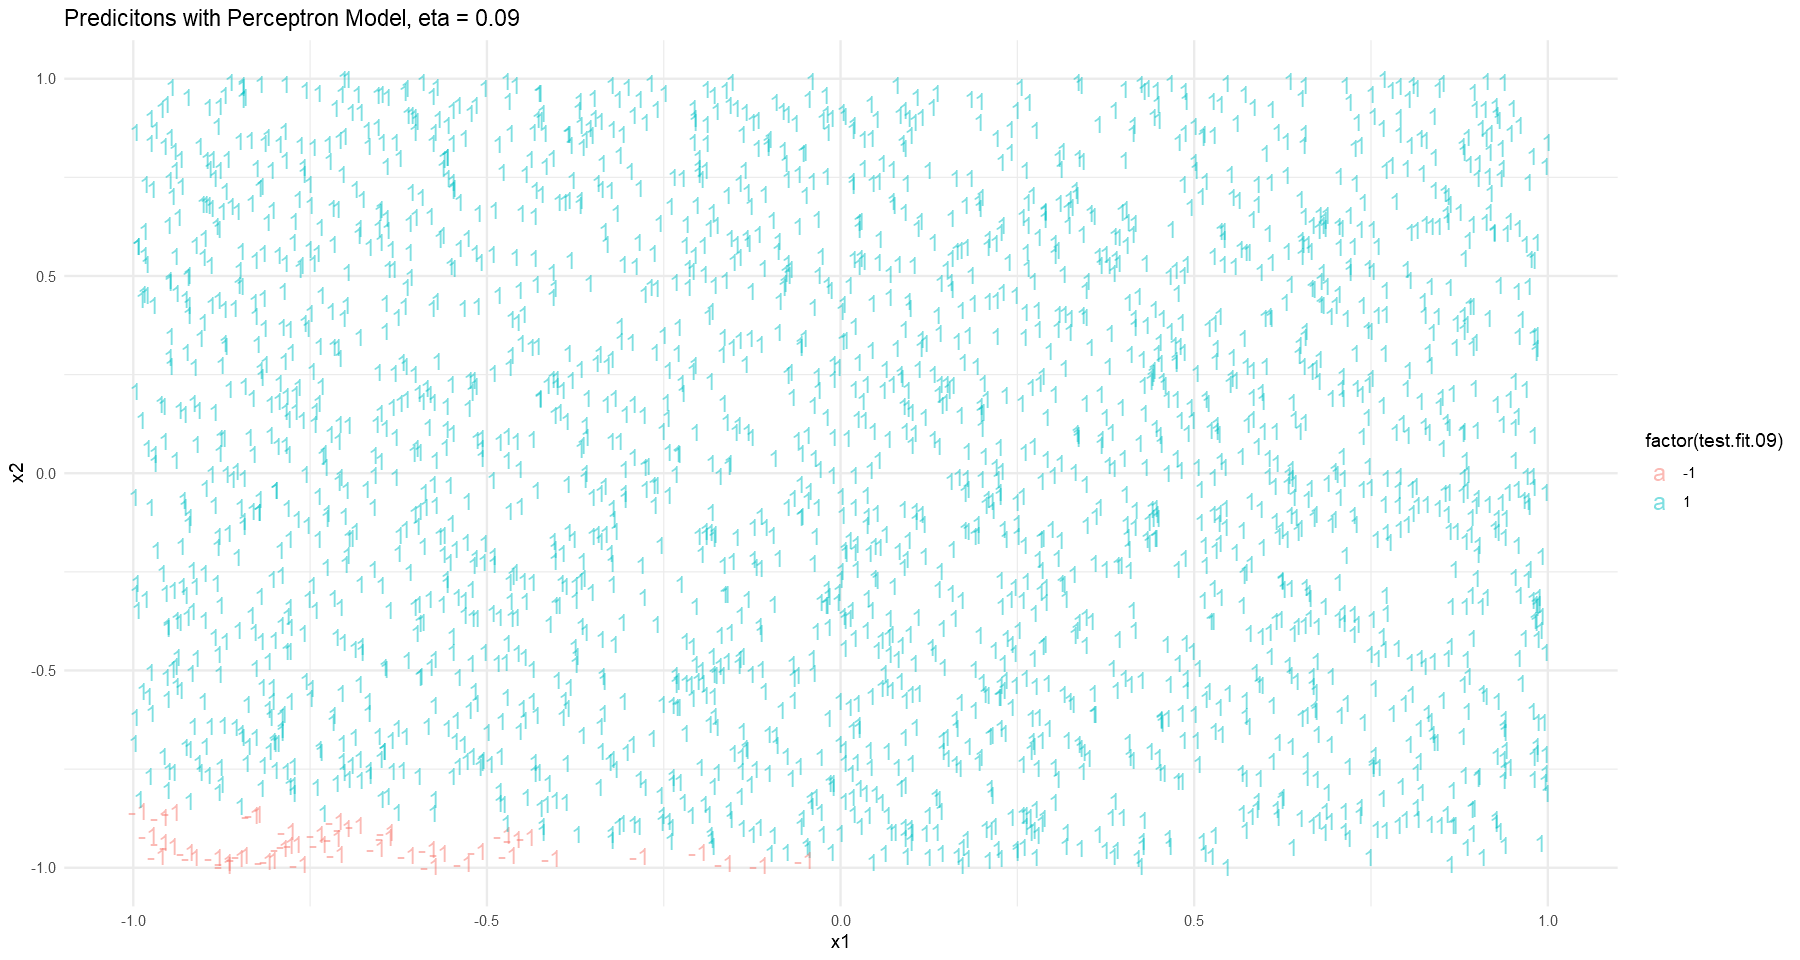

In [26]:
# visualizing the predictions
ggplot(data = test.x, aes(x = x1, y = x2, color = factor(test.fit.09), label = ifelse(factor(test.fit.09) == '-1', '-1', '1'))) +
    geom_text(size = 5, alpha = 0.5) + ggtitle ('Predicitons with Perceptron Model, eta = 0.09') + theme_minimal()

In [10]:
####################### NEURAL NET ####################### 
## the activation function (tanh here)
h <- function(z) { 
  return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}

## the derivitive of the activation function (tanh here)
h.d <- function(z) {
return (1-(h(z))^2)
}

## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## feedforward step
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}
## NN build function
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
    if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
  if (plotting){plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')}
  return(list(W1, W2, b1, b2))
}

In [83]:
# transposing the data to be passed
train.t = t(as.matrix(train.x))
test.t = t(as.matrix(test.x))
# list of values to be used
list_K = seq(5, 100, 5)
list_eta = c(0.01,0.09)
# to store error rates
error.df = data.frame('K'= integer(), 'eta' = double(), 'Error_Rate' = double())
# counter
i = 1
for (K in list_K){
    for (eta in list_eta) {
        # building th neural network
        list[W1, W2, b1, b2] = nn.build(K, train.t, train.y, plotting = FALSE, epoch.max = 100, eta, lambda = 0.01)
        # predicting the labels
        nn.fit = nn.predict(test.t, W1, W2, b1, b2)
        # error rates
        error.df[i,'Error_Rate'] = error.rate(nn.fit, test.y) * 100
        error.df[i, 'K'] = K
        error.df[i, 'eta'] = eta
        # incrementing the counter
        i = i + 1
    }
}

In [84]:
# error dataframe
error.df

K,eta,Error_Rate
5,0.01,52.52
5,0.09,39.56
10,0.01,51.52
10,0.09,37.68
15,0.01,39.56
15,0.09,27.36
20,0.01,58.08
20,0.09,21.60
25,0.01,41.68
25,0.09,22.16


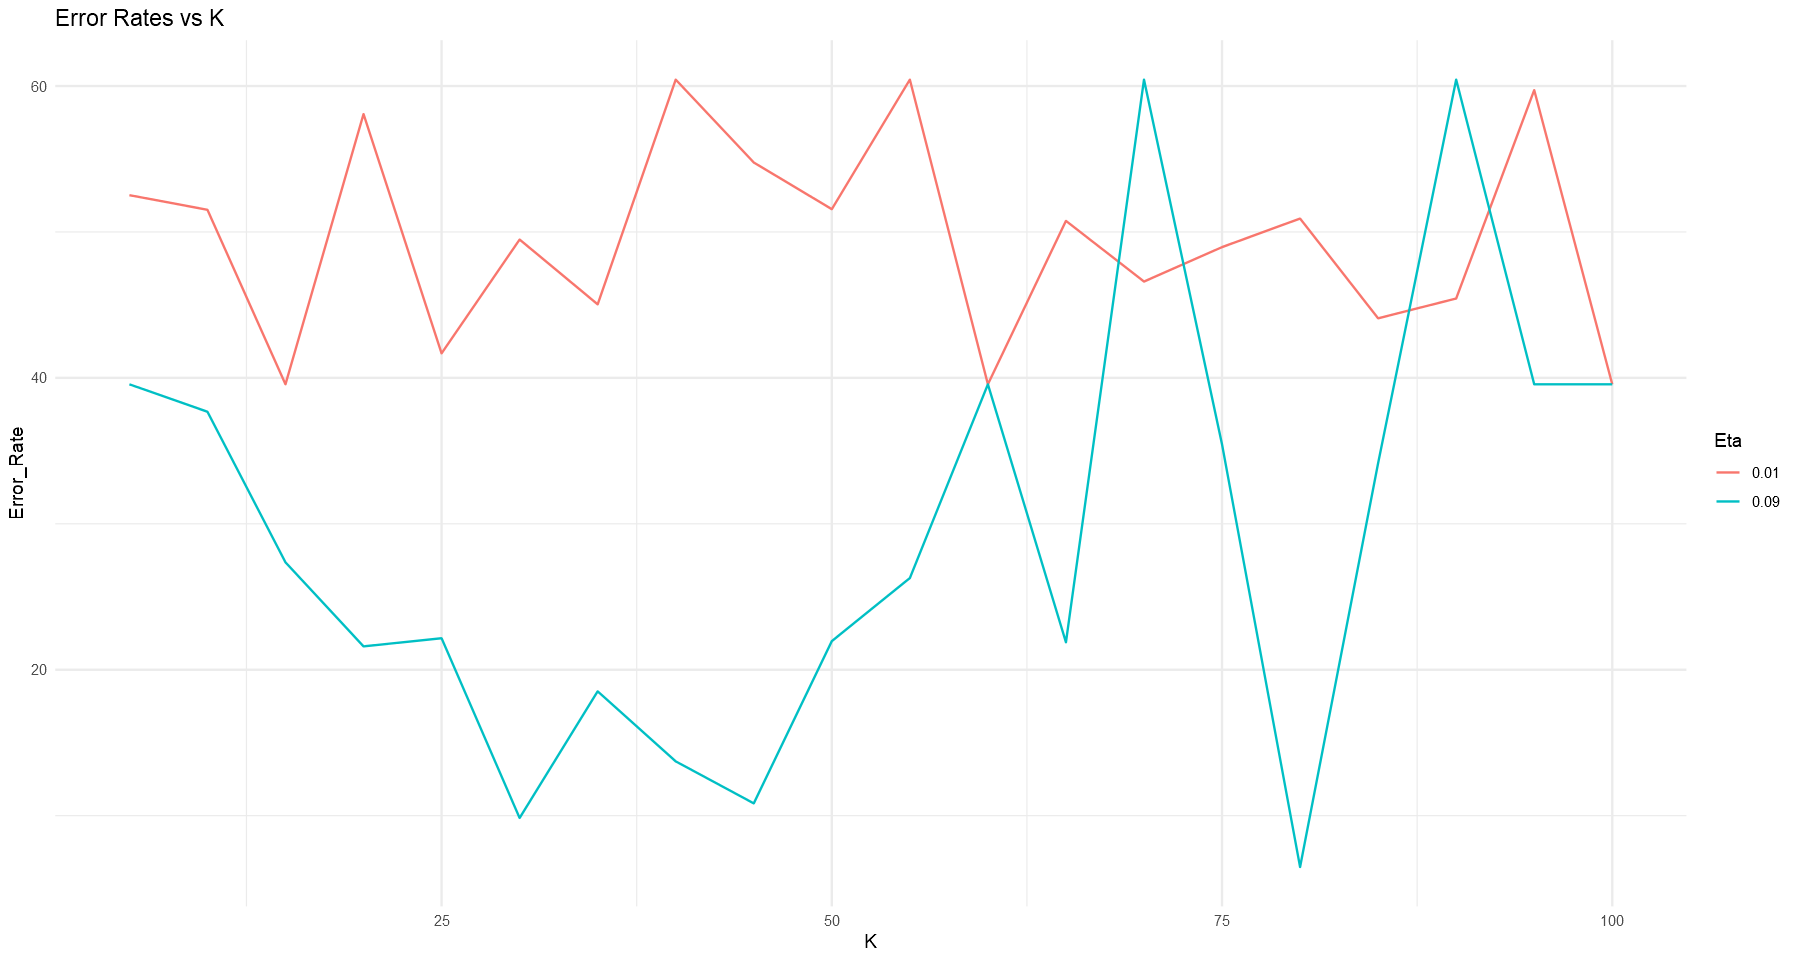

In [85]:
# visualizing the error rates with different k and eta
ggplot(data = error.df, aes(x = K, y = Error_Rate,  group = as.factor(eta), color = as.factor(eta))) +  
  labs(color='Eta')  + geom_line() + theme_minimal() + ggtitle('Error Rates vs K')

In [86]:
# getting the best value of eta and k
# value for which error is minimum
best.eta <- error.df[which.min(error.df[,'Error_Rate']),'eta']
best.K <- error.df[which.min(error.df[,'Error_Rate']),'K']
cat("Best value of eta =", best.eta, "and corresponding K =", best.K, "Error-Rate =", error.df[which.min(error.df[,'Error_Rate']),'Error_Rate'])

Best value of eta = 0.09 and corresponding K = 80 Error-Rate = 6.48

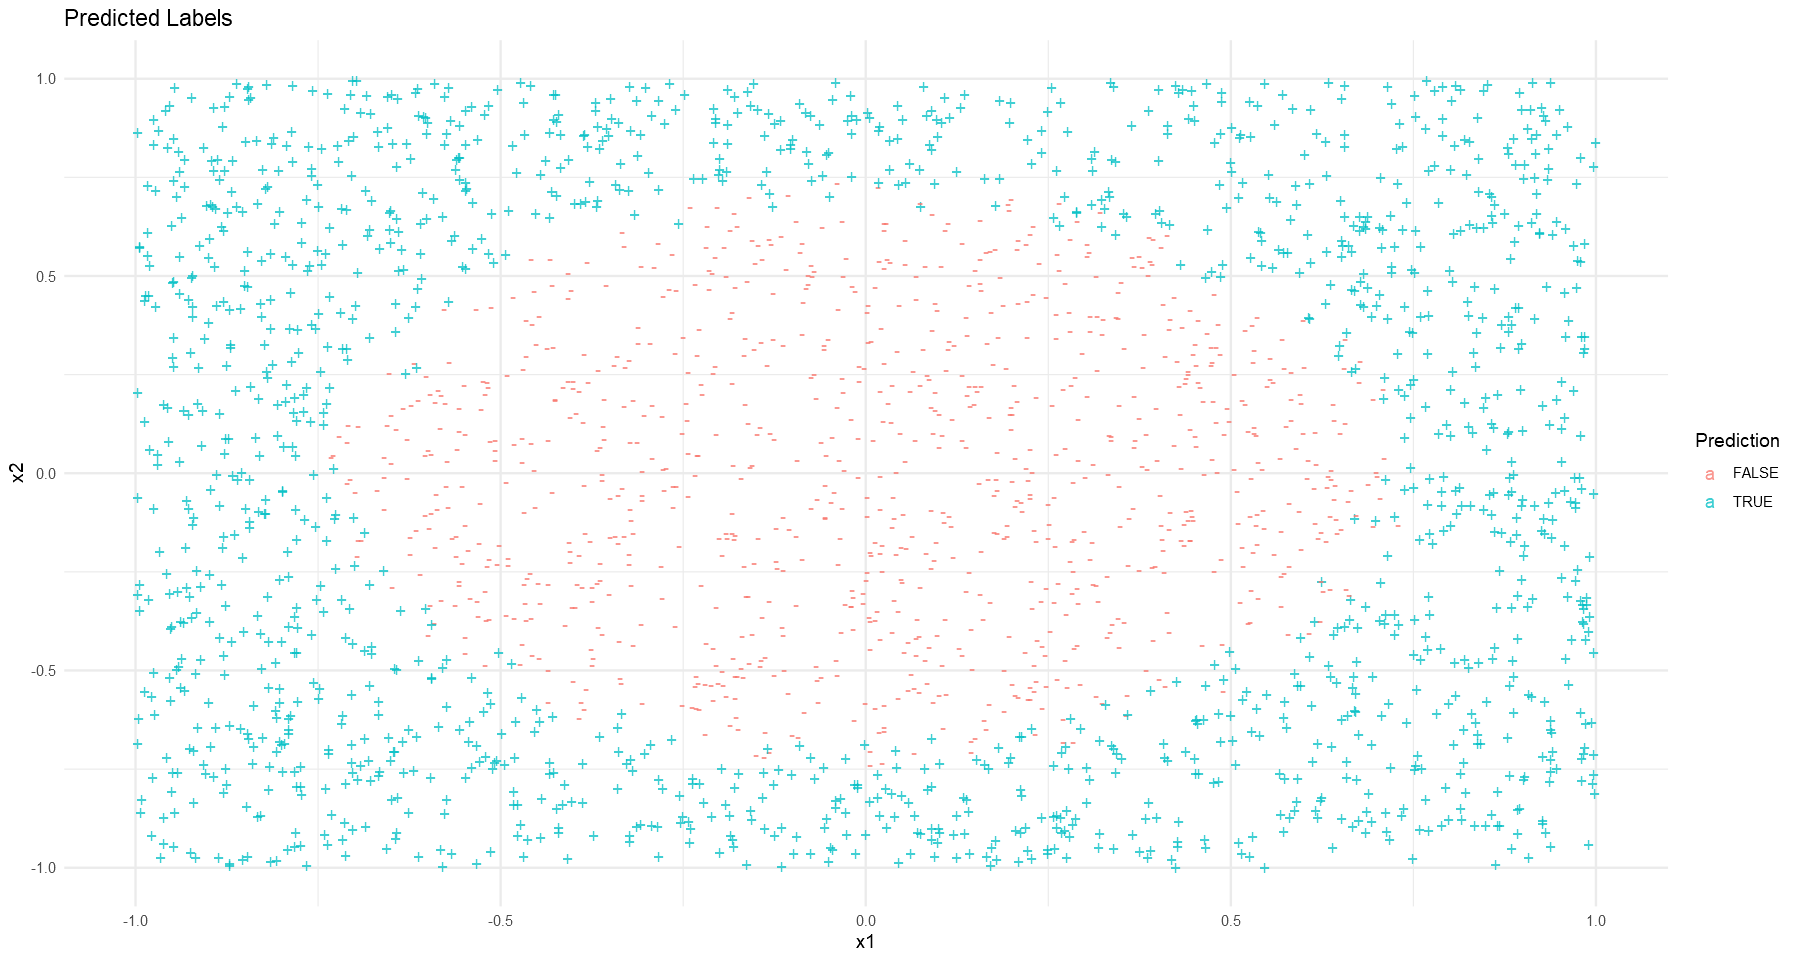

In [87]:
# Reference activity 3.1
# building the neural net with best value of  k and eta
list[W1, W2, b1, b2] = nn.build(best.K, train.t, train.y, plotting=FALSE, epoch.max = 100, eta = best.eta, lambda = 0.01)
Labels = factor(test.y)
# predicted labels with best k and eta
ggplot(data = test.x, aes(x = x1, y = x2, label = ifelse(Labels == 1, '+', '-'), 
                          color = factor(nn.predict(test.t, W1, W2, b1, b2) * test.y > 0))) +
  geom_text(alpha = 0.75) + 
  scale_color_discrete(guide = guide_legend(title = 'Prediction'))+
  ggtitle('Predicted Labels') +
  theme_minimal()